# TSCAN-A

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

### 建立时序网络

#### 导入文件

In [3]:
def t_graph(path):
    """
    path: 数据文件路径
    建立一个带t属性的静态图
    返回: 图G
    """
    G = nx.Graph()
    for line in open(path):
        if line != '/n':
            line = line.strip('\n').split('\t')
            line = [int(x) for x in line]
            if G.has_edge(line[0], line[1]):
                if line[2] not in G.edges[line[0], line[1]]['t']:
                    G.edges[line[0], line[1]]['t'].append(line[2])
            else: G.add_edge(line[0], line[1], t=[line[2]])
    return G

def snap_graph(path):
    """
    path: 数据文件路径
    返回: 字典类的多图G_d, (key='t', value=Gt)
    """
    snaps = {}
    for line in open(path):
        if line != '/n':
            line = line.strip('\n').split('\t')
            line = [int(x) for x in line]
            if line[2] not in snaps.keys():
                G = nx.Graph()
                G.add_edge(line[0], line[1])
                snaps.update({line[2]: G})
            else:
                snaps[line[2]].add_edge(line[0], line[1])
    return snaps

#### 依照论文定制的类

In [4]:
class tGraph(object):
    """
    需要传入一个带t属性的图
    """
    def __init__(self, G, eps, tau, miu):
        self.G = G.copy()
        self.G_c = nx.Graph()   # 存放sc可达的连边构成的图
        self.eps = eps
        self.tau = tau
        self.miu = miu
        self.wc = []    # 存放weak core
        self.sc = []    # 存放strong core
        self.stable_c = []  # 存放stable core
        self.all_t = set()  # 存放所有的t
        self.simu_s_neig = dict()   # keys:weakcore, values:满足simu_s>=tau的邻居
        for i in G.nodes():
            self.simu_s_neig[i] = set()
        self.c_component = []   # 存放Gc中的连通的社团

    def struc_stabi(self,u, v, t): 
        """
        输入: u, v, t ->int
        返回两个节点在某时刻下的structual stability(struc_s)
        返回: struc_s->int
        """
        # 静态图的领居
        # neig_u = G[u].keys()
        # neig_v = G[v].values()
        if t in self.G.edges[u, v]['t']:
            # 筛选t切片的(邻居+自身)集合
            neig_u_t = set([x for x in self.G[u].keys() if t in self.G.edges[u,x]['t']])
            neig_v_t = set([x for x in self.G[v].keys() if t in self.G.edges[v,x]['t']])
            neig_u_t.add(u)
            neig_v_t.add(v)
            
            # u, v共同的邻居
            neig_uv_t = (neig_u_t&neig_v_t)
            temp = len(neig_u_t)*len(neig_v_t)
            assert(temp != 0)
            struc_s = (len(neig_uv_t))/math.sqrt(temp)
        else: struc_s = 0
        return struc_s
    
    def WeakCore(self): 
        """
        计算weak core,
        更新self.wc, self.simu_s_neig
        """
        maxnode = max(self.G.nodes())
        for u in self.G.nodes():
            for v in self.G[u].keys():
                if (u>v) and (u != maxnode):continue
                count = 0
                for t in self.G.edges[u,v]['t']:
                    if self.struc_stabi(u, v, t)>=self.eps:
                        count += 1
                # print('({},{}):{}'.format(u,v,count))
                if count >= self.tau:    # u的(eps, tau)邻居出现
                    self.simu_s_neig[u].add(v)
                    self.simu_s_neig[v].add(u)
            if len(self.simu_s_neig[u]) >= self.miu:
                self.wc.append(u)

    def StrongCore(self):
        """
        在Weak Core中筛选Strong Core, 得到的即Stable Core
        sc是在wc的基础上,加上:有tau张图有miu条及以上的连接.
        更新self.sc, self.all_t
        """
        del self.sc[:]
        # 先拿到所有的t - -虽然这样子写感觉好傻
        for u, Vs in self.simu_s_neig.items():
            for v in Vs:
                self.all_t = self.all_t|set(self.G.edges[u,v]['t'])

        # 把u节点符合eps的连边记下，如果连边数大过miu的时间数目大过tau则u为sc
        for u in self.wc:
            empty = [0]*len(self.all_t)
            temp_t = dict(zip(self.all_t, empty))   # 单个快照下满足eps的连边
            count = 0
            for v in self.G[u].keys():
                for t in self.G.edges[u,v]['t']:    # TMD好多for啊，太难顶了
                    if self.struc_stabi(u, v, t) >= self.eps:
                        try:
                            temp_t[t].add(v)
                        except:
                            temp_t[t] = {v}
                        if len(temp_t[t]) >= self.miu:
                            count += 1  # 有一个符合的时间切片啦
                            # print('符合的切片：',u,v,t,temp_t[t],self.struc_stabi(u, v, t))
                            continue
            if count >= self.tau: self.sc.append(u)

    def stable_core(self):
        """
        从sc中筛选出stable_core
        """
        del self.stable_c[:]
        for u in self.sc:
            empty = [0]*len(self.all_t)
            temp_t = dict(zip(self.all_t,empty))
            for v in self.simu_s_neig[u]:
                for t in self.G.edges[u, v]['t']:
                    if self.struc_stabi(u, v, t) >= self.eps:
                        try:
                            temp_t[t].add(v)
                        except:
                            temp_t[t] = {v}
            # 把邻居数小于miu的时间删去
            for k in list(temp_t.keys()):
                if type(temp_t[k]) == type(1):
                    del temp_t[k]
                elif len(temp_t[k]) < self.miu:
                    del temp_t[k]
            if(self.is_stable_core(temp_t) == True):
                self.stable_c.append(u)


    # TODO 用消减prunning的方法从sc中算stable_c 
    def is_stable_core(self,temp_t):
        """
        u->节点,    temp_t->某一时间切片下,u的eps-edges
        用3滑窗扫描的方式看看u是否存在<=tau的,完全一样的星状结构
        """
        for i in temp_t.keys():
            for j in temp_t.keys():
                for k in temp_t.keys():
                    if i<j<k:
                        same_node = set(temp_t[i])&set(temp_t[j])&set(temp_t[k])
                        if len(same_node)>=3:
                            return  True
                        else:   return False

    
    def reachable(self,method='TSCNA-A'):
        """
        把对于strong core节点来说structual reachable的连边加入到Gc中
        method = ['TSCNA-A', 'TSCNA-S']
        更新Gc
        """
        if method == 'TSCNA-A':
            core = self.stable_c
        else:core = self.sc
        for u in core:
            edges = [(u, v) for v in self.simu_s_neig[u]]
            self.G_c.add_edges_from(edges)
        self.c_component = [i for i in nx.connected_components(self.G_c)]
        

### 出表

1. 数据统计表：图的节点、静态图连边、时序图连边和、最大数量的时序连边的节点度、快照数

In [5]:
# 静态
G_chess = t_graph('chess_year')
print('节点数：', len(G_chess.nodes))
print('静态图连边数：', len(G_chess.edges()))

# 时序
snaps = snap_graph('chess_year')
t_edges = 0
biggest_d = 0
for k, v in snaps.items():
    t_edges += len(v.edges())
    for d in v.degree():
        if d[1] > biggest_d:
            biggest_d = d[1]

print('时序图连边和：', t_edges)
print('快照中最大度值：', biggest_d)
print('快照数：', len(snaps.keys()))



节点数： 7301
静态图连边数： 55899
时序图连边和： 62385
快照中最大度值： 52
快照数： 9


### 出图

1. 快照的连边数与节点数
2. 时序与静态图的度分布

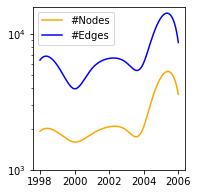

In [6]:
# 画快照的连边数与节点数
x = np.array(list(snaps.keys()))
y_1 = np.zeros((x.shape))
y_2 = np.zeros((x.shape))
for i in range(len(x)):
    y_1[i] = len(snaps[x[i]].nodes)
    y_2[i] = len(snaps[x[i]].edges())

# 样条插值
y1_mod =  make_interp_spline(x,y_1)
y2_mod = make_interp_spline(x,y_2)
x_s = np.linspace(min(x), max(x), (max(x)-min(x))*50)

ys_1 = y1_mod(x_s)
ys_2 = y2_mod(x_s)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_s, ys_1, color = 'orange', label = '#Nodes') # TODO 转换成指数纵轴
plt.plot(x_s, ys_2, color = 'b', label = '#Edges')
plt.yscale('log')
plt.yticks([1000, 10000],[r'$10^3$', r'$10^4$',])
plt.legend()

# 画静态图的度分布
y_det = [i/sum(nx.degree_histogram(G_chess)) for i in nx.degree_histogram(G_chess)] # degree temporary度分布
x_degree = list(range(max(dict(G_chess.degree()).values())+1))
y_t = np.array([], dtype=int)

3. 对单个网络每个快照的社团划分求separability, density, cohesiveness and clustering coefficient, 对比不同的手段（TSCAN-S、PSCAN-W）
4. 对多个网络计算以上方法得到的参数的平均的数值

In [7]:
class clust_evaluation(object):
    def __init__(self, G, Gc, c_component):
        """
        Input: G是静态图, Gc是衰减社团间连边后的图
        旨在计算社团划分平均评估指标:separability, density, cohesiveness and clustering coefficient
        """
        self.G = G
        self.Gc = Gc
        self.communities = c_component
    
    def AS(self):
        """
        计算平均分离度: 社团内部连边数量/(社团内节点所有连边数量)
        Return: AS
        """
        comm_num = len(self.communities)
        insideC_e = np.zeros(comm_num) #   inside community edges
        allC_e = np.zeros(comm_num)
        for i in range(comm_num):
            insideC_e[i] = len(self.Gc.edges(self.communities[i]))
            allC_e[i] = len(self.G.edges(self.communities[i]))
        sep = insideC_e/allC_e
        ave_sep = np.mean(sep)
        return ave_sep

In [8]:
def main(path, eps, tau, miu):
    G_test = t_graph(path)
    G_A = tGraph(G_test, eps, tau, miu)

    # 返回weakcore 
    G_A.WeakCore()
    G_A.StrongCore()
    G_A.stable_core()

    print('Strong Core:',G_A.sc)
    print('Stable Core', G_A.stable_c)
    G_A.reachable('TSCNA-S')
    print('社团的连边：', G_A.G_c.edges())
    print('连通片', G_A.c_component)

    eva = clust_evaluation(G_test, G_A.G_c, G_A.c_component)
    ave_sep = eva.AS()
    print("AS:", ave_sep)

main('chess_year', 0.5, 3, 5)     #    也可以用test_sample测试
# main('test_sample', 0.7, 3, 3)

Strong Core: [172, 269, 280, 674]
Stable Core []
社团的连边： [(172, 352), (172, 322), (172, 2028), (172, 952), (172, 90), (269, 2209), (269, 130), (269, 712), (269, 41), (269, 152), (280, 801), (280, 13), (280, 2574), (280, 1108), (280, 439), (674, 663), (674, 2090), (674, 652), (674, 722), (674, 759)]
连通片 [{352, 322, 172, 2028, 952, 90}, {2209, 130, 712, 41, 269, 152}, {801, 13, 2574, 1108, 439, 280}, {674, 2090, 759, 652, 722, 663}]
AS: 0.014731655249805159
